In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import utils
from ImageMatcher import ImageMatcher, ImagePair
import h5py
from scipy.spatial.transform import Rotation as Rot
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
from glob import glob
import os
import sys

In [54]:
DATA_DIR = '/Users/richard/Desktop/Motorized-Dataset/'
TRAJ_DIR = DATA_DIR

in_vid_paths = sorted(glob(DATA_DIR + '*.mp4'))

in_vid_path = in_vid_paths[0]
in_vid_stem = Path(in_vid_path).stem

frames = utils.load_video(in_vid_path,
                          grayscale=True)
masks = np.load(DATA_DIR + in_vid_stem + '-masks.npz')['masks']
video_width = frames[0].shape[1]

kf_interval = 30

print('Using video:', in_vid_stem)
print('n_frames:', len(frames))

Using video: t000-v00
n_frames: 900


In [55]:
matcher = ImageMatcher(frames, human_masks=masks, keyframe_interval=kf_interval)

In [56]:
img_pairs_path = DATA_DIR + in_vid_stem + '-pairs.h5'
image_pairs = []
closures = []
still_cnt = 0
override = False

if not override and os.path.isfile(img_pairs_path):
    print('Loading existing file', img_pairs_path)
    image_pairs = utils.import_image_pairs(img_pairs_path, frames)
    for p in image_pairs:
        if p.still:
            still_cnt += 1
        if p.i != p.j - 1:
            closures.append(p)
else:

    for i in range(0, len(frames) - 1):
        p = matcher.match(
            i, i+1,
            min_match_count=60,
            ransac_max_iters=2000,
            #keep_percent=0.5,
            verbose=True,
        )
        if p is None:
            print('No match found for frames', i, i+1)
        image_pairs.append(p)

    for i in range(0, len(frames) - kf_interval, kf_interval):
        for j in range(i + kf_interval, len(frames), kf_interval):
            if matcher.sift_kds[i] is None or matcher.sift_kds[j] is None:
                continue
            p = matcher.match(i, j, 'sift',
                            min_match_count=25)
            if p is None:
                continue
            closures.append(p)
            image_pairs.append(p)


print('Number of loop closures:', len(closures))

print('Total number of image pairs:', len(image_pairs))

print('Number of still pairs:', still_cnt)

if override or (not os.path.isfile(img_pairs_path)):
    utils.export_image_pairs(img_pairs_path, image_pairs)

Number of loop closures: 36
Total number of image pairs: 935
Number of still pairs: 0


In [10]:
# 13 seconds
image_pairs = matcher.lk_track()
utils.export_image_pairs(img_pairs_path, image_pairs)

100%|██████████| 900/900 [00:12<00:00, 72.95it/s] 


In [ ]:
for p in closures:
    print(f'Number of matches from {p.i} to {p.j}: {len(p.src_pts)}')
    utils.visualize_matches(p)

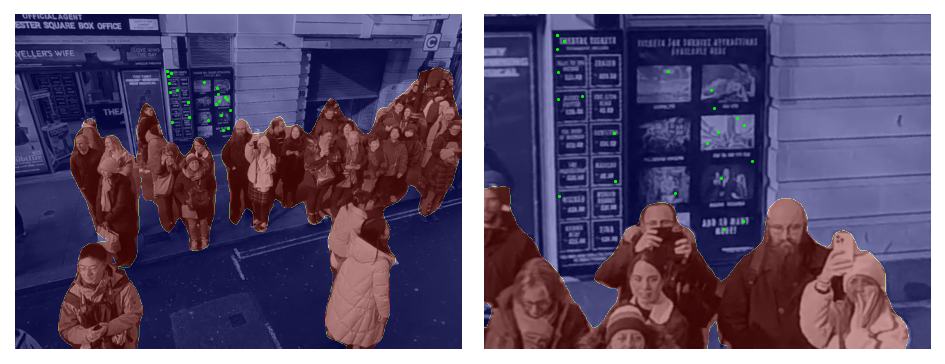

In [45]:
for p in image_pairs:
    if (p.i, p.j) == (150, 570):
        utils.visualize_matches(p, dpi=150, masks=masks)

In [97]:
opt_cmd = [
    '../Ceres/build/estimate', DATA_DIR, in_vid_stem + '-pairs.h5',
    'yes',  # enable loop closures
    'yes',  # load existing camera params
    'yes',   # use_stills
]
ret = subprocess.run(opt_cmd)
if ret.returncode != 0:
    print(f'Ceres exited with non-zero return code!')

Enabling loop closure constraints.
Optimizing poses for t000-v00.
Loaded 935 image pairs.
Num objects in file: 900
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.484857e+08    0.00e+00    2.53e+08   0.00e+00   0.00e+00  1.00e+04        0    1.70e-01    3.27e-01
   1  1.478377e+07    1.34e+08    4.32e+07   0.00e+00   9.05e-01  2.13e+04        1    3.12e-01    6.39e-01
   2  6.851253e+05    1.41e+07    5.34e+06   1.56e+03   9.69e-01  6.40e+04        1    2.23e-01    8.62e-01
   3  1.004337e+05    5.85e+05    9.40e+05   1.40e+03   9.67e-01  1.92e+05        1    2.17e-01    1.08e+00
   4  5.698776e+04    4.34e+04    1.88e+05   1.26e+03   1.02e+00  5.76e+05        1    2.17e-01    1.30e+00
   5  5.443488e+04    2.55e+03    1.50e+04   4.42e+02   1.13e+00  1.73e+06        1    2.40e-01    1.54e+00
   6  5.422309e+04    2.12e+02    1.20e+04   2.14e+02   1.37e+00  5.19e+06        1    2.30e-01    1.77e+00
   7  5.417575e+04   

angular error mean: 1.35511, max: 3.86327
hfov error mean: 0.55923, max: 1.82473


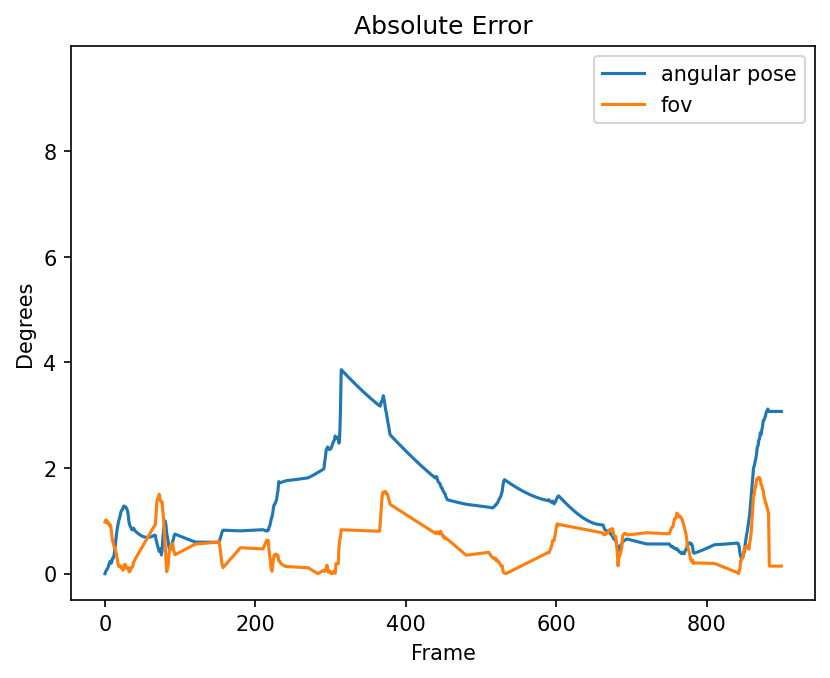

In [98]:
cpe, cpg = utils.load_est_gt_poses(
    in_vid_path, video_width)

cam_params_est, cam_params_gt = utils.set_ref_cam(0, cpe, cpg)

# Compute the angular pose error and hfov error between cam_params and cam_params_gt
angular_err_abs = []
angular_err_rel = []
hfov_err_abs = []
hfov_err_rel = []
cam_indices = []

for i in sorted(cam_params_est.keys()):
    R = cam_params_est[i]['R']
    R_gt = cam_params_gt[i]['R']

    ae = np.degrees(Rot.from_matrix(R @ R_gt.T).magnitude())
    angular_err_abs.append(ae)
    angular_err_rel.append(ae / max(np.degrees(Rot.from_matrix(R_gt.T).magnitude()), 0.1))

    hfove = np.abs(cam_params_est[i]['hfov'] - cam_params_gt[i]['hfov'])
    hfov_err_abs.append(hfove)
    hfov_err_rel.append(hfove / cam_params_gt[i]['hfov'])
    cam_indices.append(i)

print(f'angular error mean: {np.mean(angular_err_abs):.5f}, '
      f'max: {np.max(angular_err_abs):.5f}')
print(f'hfov error mean: {np.mean(hfov_err_abs):.5f}, max: {np.max(hfov_err_abs):.5f}')

fig, ax = plt.subplots(dpi=150)
ax.set_title('Absolute Error')
ax.plot(angular_err_abs, label='angular pose')
ax.plot(hfov_err_abs, label='fov')
ax.set_xlabel('Frame')
ax.set_ylabel('Degrees')
ax.set_ylim(-0.5, 10)
ax.set_yticks(np.arange(0, 8.5, 2))
ax.legend()
plt.show()

In [ ]:
hfov_err_abs[3]

In [ ]:
utils.visualize_matches(image_pairs[1])

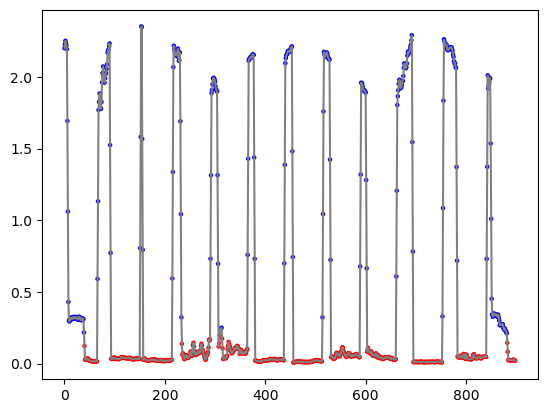

In [92]:
idx2pair = {}
for p in image_pairs:
    idx2pair[(p.i, p.j)] = p

av = []
for i in range(0, len(frames) - 1):
    p = idx2pair[(i, i+1)]
    av.append(utils.avg_quad_angular_velocity(p, cam_params_est[i]))

# Moving average filter to smooth out the angular velocity
# preserve the length of the array (padding = same as edge)
av.insert(0, av[0])
av.append(av[-1])
av = np.convolve(av, np.ones(3) / 3, mode='valid')

still_thresh = 0.2
plt.plot(av, color='gray')
plt.scatter(np.arange(0, len(av)), av, c=['red' if a < still_thresh
                                          else 'blue' for a in av], s=5)
plt.show()

In [96]:
cnt = 0
for i in range(0, len(av)):
    p = idx2pair[(i, i+1)]
    p.still = av[i] < still_thresh
    if p.still:
        cnt += 1
print(f'Number of still pairs: {cnt}')

utils.export_image_pairs(img_pairs_path, image_pairs)

Number of still pairs: 618
